In [656]:
import networkx as nx
import osmnx as ox
import numpy as np
import warnings
warnings.filterwarnings('ignore')

tube_color_dict = {
	'Bakerloo': "#ae6118",
	'Central': "#ae6118",
	'District': "#00a575",
	'Circle': "#f8d42d",
    'DLR': "#00bbb4",
    'Hammersmith and City': "#e899a8",
	'Jubilee': "#8f989e",
	'Metropolitan': "#893267",
	'Northern': "#1C1C1C",
    'Overground': "#F86C00",
	'Piccadilly': "#0450a1",
	'Victoria': "#009fe0",
	'Waterloo and City': "#70c3ce",
    'Elizabeth': "#603E99"
}

MAP_PATH = "./data/london.graphml"
MAP_TUBE_PATH = "./data/london_tube.graphml"

LONDON_NORTH, LONDON_SOUTH, LONDON_EAST, LONDON_WEST = 51.672343, 51.384940, 0.148271, -0.351468

WALKING_SPEED = 1.34112 # m/s
WALKING_SPEED_MALE = 1.4 # m/s
WALKING_SPEED_FEMALE = 1.31 # m/s
WALKING_SPEED_YOUNG = 1.45 # m/s
WALKING_SPEED_OLD = 1.19 # m/s

WK_WEIGHT = 1

tube_speeds = [27.04, 37.29, 24.31, 29.44, 27.65, 40.32, 44.14, 34.09, 32.65, 42.49, 33.30]
TRANSPORT_SPEED =  (np.mean(tube_speeds) - 15) / 3.6 # km/h to m/s

In [657]:
origin_address = 'Euston Station, London, UK'
dest_address = 'Excel London, London, UK'
address_compact = origin_address.split(",")[0].replace(" ", "_") + '-' + dest_address.split(",")[0].replace(" ", "_")
origin_lat, origin_lon = ox.geocode(origin_address)
dest_lat, dest_lon = ox.geocode(dest_address)

In [658]:
def get_bbox_bound_from_coord(lat1, lon1, lat2, lon2):
    north, south, east, west = -100, 100, -100, 100
    if lat1 > north: north = lat1
    if lat2 > north: north = lat2
    if lat1 < south: south = lat1
    if lat2 < south: south = lat2
    if lon1 > east: east = lon1
    if lon2 > east: east = lon2
    if lon1 < west: west = lon1
    if lon2 < west: west = lon2

    diff = 0.03
    
    return north+diff, south-diff, east+diff, west-diff

In [647]:
# G = ox.graph_from_bbox(51.54, 51.48, -0.01, -0.16, network_type="walk")
north, south, east, west = get_bbox_bound_from_coord(origin_lat, origin_lon, dest_lat, dest_lon)
G = ox.graph_from_bbox(north, south, east, west, network_type="walk")
# ox.save_graphml(G, MAP_PATH)

In [648]:
# fig, ax = ox.plot_graph(
#     G,
#     ax=None,  # optionally draw on pre-existing axis
#     figsize=(8, 8),  # figure size to create if ax is None
#     bgcolor="#111111",  # background color of the plot
#     node_color="w",  # color of the nodes
#     node_size=1,  # size of the nodes: if 0, skip plotting them
#     node_alpha=None,  # opacity of the nodes
#     node_edgecolor="none",  # color of the nodes' markers' borders
#     node_zorder=1,  # zorder to plot nodes: edges are always 1
#     edge_color="#999999",  # color of the edges
#     edge_linewidth=1,  # width of the edges: if 0, skip plotting them
#     edge_alpha=None,  # opacity of the edges
#     show=True,  # if True, call pyplot.show() to show the figure
#     close=False,  # if True, call pyplot.close() to close the figure
#     save=False,  # if True, save figure to disk at filepath
#     filepath=None,  # if save is True, the path to the file
#     dpi=300,  # if save is True, the resolution of saved file
#     bbox=None,  # bounding box to constrain plot
# )

In [649]:
# G = ox.load_graphml(MAP_PATH)

origin, dist1 = ox.nearest_nodes(G, origin_lon, origin_lat, return_dist=True)
dest, dist2 = ox.nearest_nodes(G, dest_lon, dest_lat, return_dist=True)


In [650]:
# add weights to walking edges based on age/gender
for u, v, k, data in G.edges(data=True, keys=True):
    data['color'] = '#AAFF00'
    distance = data["length"]
    data["time"] = data["time_fake"] = round(distance / WALKING_SPEED * WK_WEIGHT)
    data["time_male"] = round(distance / WALKING_SPEED_MALE)
    data["time_female"] = round(distance / WALKING_SPEED_FEMALE)
    data["time_young"] = round(distance / WALKING_SPEED_YOUNG)
    data["time_old"] = round(distance / WALKING_SPEED_OLD)
    # print(f"distance: {round(data['length'], 3)} m \twk time: {round(data['time_old'], 3)} seconds (old)")
    # print(f"distance: {round(data['length'], 3)} m \twk time: {round(data['time_female'], 3)} seconds (female)")
    # print(f"distance: {round(data['length'], 3)} m \twk time: {round(data['time'], 3)} seconds (google)")
    # print(f"distance: {round(data['length'], 3)} m \twk time: {round(data['time_male'], 3)} seconds (male)")
    # print(f"distance: {round(data['length'], 3)} m \twk time: {round(data['time_young'], 3)} seconds (young)")

In [651]:
import json

with open('input/LondonTubeLines_minimal.json', 'r') as f:
    data = json.load(f)

tube_lines, route_colors = [], []
stations_osmid = set()
# Iterating through the json list
for tube_route in data['features']:
    start_end = tube_route['geometry']['coordinates']
    orig_lon, orig_lat = start_end[0][0], start_end[0][1]
    end_lon, end_lat = start_end[1][0], start_end[1][1]

    orig_node, dist1 = ox.nearest_nodes(G, orig_lon, orig_lat, return_dist=True)
    end_node, dist2 = ox.nearest_nodes(G, end_lon, end_lat, return_dist=True)

    # ignore stations and routes that are not within 50m of the graph
    if dist1 > 50 or dist2 > 50:
        continue

    stations_osmid.add(orig_node)
    stations_osmid.add(end_node)

    line_color = tube_route['properties']['stroke']
    feature_str = tube_route['properties']['name'].split(' - ')
    line_name = feature_str[0]
    start_station_name = feature_str[1].split(' to ')[0].split(' (')[0]
    end_station_name = feature_str[1].split(' to ')[1].split(' (')[0]

    # add line info to start station
    G.nodes[orig_node]['station_name'] = start_station_name

    try: 
        G.nodes[orig_node]['lines_name'].add(line_name)
    except (KeyError, AttributeError) as e:
        G.nodes[orig_node]['lines_name'] = {line_name}
    
    # add line info to end station
    G.nodes[end_node]['station_name'] = end_station_name

    try: 
        G.nodes[end_node]['lines_name'].add(line_name)
    except (KeyError, AttributeError) as e:
        G.nodes[end_node]['lines_name'] = {line_name}

    # print(f"{G.nodes[orig_node]['station_name']}: {G.nodes[orig_node]['lines_name']}")
    # print(f"{G.nodes[end_node]['station_name']}: {G.nodes[end_node]['lines_name']}")

    G.add_edge(orig_node, end_node, color=tube_route['properties']['stroke'])
    tube_lines.append(nx.shortest_path(G, orig_node, end_node))
    route_colors.append(tube_route['properties']['stroke'])

ox.distance.add_edge_lengths(G)

In [652]:
# G = ox.load_graphml(MAP_TUBE_PATH)
# add weight to tp edges
for u, v, k, data in G.edges(data=True, keys=True):
    if 'time' not in data:
        data['travel_mode'] = 'tp'
        data["time"] = data["time_male"] = data["time_female"] = data["time_young"] = data["time_old"] = data["length"] / TRANSPORT_SPEED
        # data["time_fake"] = data["length"] / TRANSPORT_SPEED_FAKE
        # print(f"distance: {round(data['length'], 3)} m \ttp time: {round(data['time'], 3)} seconds")

In [653]:
# plot london tube maps on top of walking map
# fig, ax = ox.plot_graph_routes(G, tube_lines, route_linewidths=2, route_colors=route_colors, route_alpha=.8, \
#                                node_color='w', node_size=.2, orig_dest_size=30, edge_linewidth=0.3, edge_color="dimgrey", edge_alpha=.7, \
#                                dpi=300)

# fig.savefig(f"output/map_central_{address_compact}.png", dpi=300, bbox_inches='tight')

In [654]:
route = nx.shortest_path(G, origin, dest, weight="time")
print(route)

[3359292033, 3359292030, 3359292024, 3359292018, 1760542333, 1264708174, 2833955781, 4305326861, 26559371, 9904350256, 25476051, 6505620197, 5361364375, 2583800691, 9001963694, 7643266983, 6596649300, 2476562725, 4943230240, 8350209881, 4943230230, 8350209887, 8354781887, 8354781893, 8354781884, 8511153807]


In [655]:
def get_bbox_bound(node_list):
    north, south, east, west = -100, 100, -100, 100
    for node in node_list:
        if G.nodes[node]['y'] > north:
            north = G.nodes[node]['y']
        if G.nodes[node]['y'] < south:
            south = G.nodes[node]['y']
        if G.nodes[node]['x'] > east:
            east = G.nodes[node]['x']
        if G.nodes[node]['x'] < west:
            west = G.nodes[node]['x']
    diff = 0.02
    return north+diff, south-diff, east+diff, west-diff


Start at : Euston Station, London, UK
1. 🚄 From [Euston] take Victoria line
   -> to [Oxford Circus]
2. 🚄 Change at [Oxford Circus] to Bakerloo line
   -> to [Charing Cross]
3. 🚄 Change at [Charing Cross] to Northern line
   -> to [Waterloo]
4. 🚄 Change at [Waterloo] to Jubilee line
   -> to [Canary Wharf]
5. 🚄 Change at [Canary Wharf] to Elizabeth line
   -> Get off at [Custom House]
6. 🚶🏻 Walk
Reaching destination: Excel London, London, UK
Transfers: 6 times


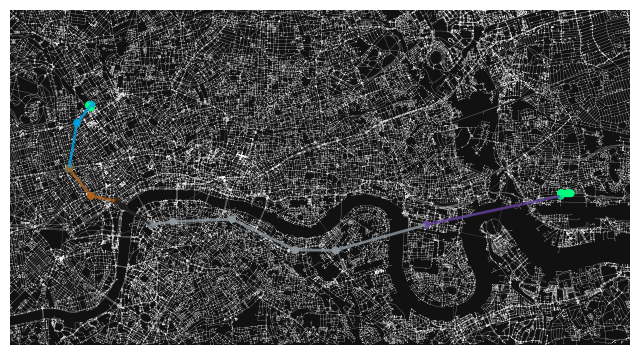

In [641]:
# plot route with diff colours for diff transport modes
recommended_routes = []
recommended_routes_color = []
transfer = 0

print(f"Start at : {origin_address}")

last_travel_mode = 'walk'
last_travel_stop = origin
last_station = ''

for i in range(len(route)-1):
    start_node, end_node = route[i], route[i+1]
    recommended_routes.append([start_node, end_node])
    if 'lines_name' in G.nodes[start_node] and 'lines_name' in G.nodes[end_node]:
        tube_line = set.intersection(G.nodes[start_node]['lines_name'], G.nodes[end_node]['lines_name']).pop()
        recommended_routes_color.append(tube_color_dict[tube_line])
        if last_travel_mode != 'walk' and last_travel_mode != tube_line:
            print(f"   -> to [{last_station}]")
        last_station = G.nodes[end_node]['station_name']
        travel_mode = tube_line
    else:
        travel_mode = 'walk'
        recommended_routes_color.append('springgreen')
    
    if last_travel_mode != travel_mode:
        transfer += 1
        if last_travel_mode == 'walk':
            print(f"{transfer}. 🚄 From [{G.nodes[start_node]['station_name']}] take {tube_line} line")
        elif travel_mode == 'walk':
            if last_station != '':
                print(f'   -> Get off at [{last_station}]')
            print(f'{transfer}. 🚶🏻 Walk')
        else:
            print(f"{transfer}. 🚄 Change at [{G.nodes[start_node]['station_name']}] to {tube_line} line")

    last_travel_mode = travel_mode

print(f"Reaching destination: {dest_address}")
print(f"Transfers: {transfer} times")

north, south, east, west = get_bbox_bound(route)

fig, ax = ox.plot_graph_routes(G, recommended_routes, route_linewidths=2, route_colors=recommended_routes_color, route_alpha=.8, \
                            node_color='w', node_size=.2, orig_dest_size=30, edge_linewidth=0.3, edge_color="dimgrey", edge_alpha=.7, \
                            bbox=(north, south, east, west), dpi=300) #, 

fig.savefig(f"output/route_{address_compact}.png", dpi=300, bbox_inches='tight')

In [642]:
total_time = nx.dijkstra_path_length(G, origin, dest, weight="time")
print(f"Total time: {round(total_time/60, 3)} minutes")
total_time = nx.dijkstra_path_length(G, origin, dest, weight="time_old")
print(f"Total time: {round(total_time/60, 3)} minutes (old)")
total_time = nx.dijkstra_path_length(G, origin, dest, weight="time_female")
print(f"Total time: {round(total_time/60, 3)} minutes (female)")
total_time = nx.dijkstra_path_length(G, origin, dest, weight="time_male")
print(f"Total time: {round(total_time/60, 3)} minutes (male)")
total_time = nx.dijkstra_path_length(G, origin, dest, weight="time_young")
print(f"Total time: {round(total_time/60, 3)} minutes (young)")

Total time: 50.42 minutes
Total time: 51.17 minutes (old)
Total time: 50.553 minutes (female)
Total time: 50.203 minutes (male)
Total time: 49.987 minutes (young)


In [643]:
original_waypoints = [{'lat': 51.51629149999999, 'lng': -0.1755034}, {'lat': 51.507504, 'lng': -0.128672}, {'lat': 51.5076022, 'lng': -0.1289566}, {'lat': 51.5128431, 'lng': -0.1185001}, {'lat': 51.51305350000001, 'lng': -0.1175648}]
alt1_waypoints = [{'lat': 51.516482, 'lng': -0.1779082}, {'lat': 51.5143352, 'lng': -0.1488549}, {'lat': 51.5145647, 'lng': -0.1473793}]
alt2_waypoints = [{'lat': 51.51439999999999, 'lng': -0.149408}, {'lat': 51.517746, 'lng': -0.119719}, {'lat': 51.51305350000001, 'lng': -0.1175648}]
original_travel_modes = [('Walking', 'Walk to Paddington'), ('Transit', 'Subway'), ('Walking', 'Walk to Trafalgar Square (Stop B)'), ('Transit', 'Bus'), ('Walking', 'Walk to 30 Aldwych, London WC2B 4BG, UK')]
alt1_travel_modes = [('Walking', 'Walk to Paddington'), ('Transit', 'Train'), ('Walking', 'Walk to Bond Street, Bond Street Station Underground Ltd, Oxford St, London W1R 1FE, UK')]
alt2_travel_modes = [('Walking', 'Walk to Bond Street'), ('Transit', 'Subway'), ('Walking', 'Walk to 30 Aldwych, London WC2B 4BG, UK')]

# plot routes

# paths = []
# route_colors = []
# for i in range(1, len(original_waypoints)):
#     origin = original_waypoints[i-1]['lng'], original_waypoints[i-1]['lat']
#     end = original_waypoints[i]['lng'], original_waypoints[i]['lat'] # find the nearest node to the start location
#     orig_node = ox.nearest_nodes(G, origin[0], origin[1])
#     end_node = ox.nearest_nodes(G, end[0], end[1])
#     if original_travel_modes[i][0] == "Walking":
#         route_colors.append("cornflowerblue")
#     else:
#         route_colors.append("gainsboro")
        
#     paths.append(nx.dijkstra_path(G, orig_node, end_node, weight="time"))
    
# # print(G.edges)
# fig, ax = ox.plot_graph_routes(G, paths, route_linewidths=3, route_colors=route_colors, route_alpha=.9, node_color='dimgrey', \
#                                edge_linewidth=0.3, edge_alpha=.7, edge_color="dimgrey", orig_dest_size=50, node_size=.4, \
#                                 bbox=(51.535, 51.49, -0.08457, -0.183919), dpi=300, ax=ax)
# # fig, ax = ox.plot_graph_routes(G, paths, route_linewidth=2, route_color=route_colors, route_alpha=1, node_size=.2)

# fig.savefig("output/map_original_bush_house.png", dpi=300, bbox_inches='tight')
# fig.clf()


# paths = []
# route_colors = []
# alt_waypoints = alt1_waypoints + alt2_waypoints
# alt_travel_modes = alt1_travel_modes + alt2_travel_modes
# for i in range(1, len(alt_waypoints)):
#     origin = alt_waypoints[i-1]['lng'], alt_waypoints[i-1]['lat']
#     end = alt_waypoints[i]['lng'], alt_waypoints[i]['lat']# find the nearest node to the start location
#     orig_node = ox.nearest_nodes(G, origin[0], origin[1])
#     end_node = ox.nearest_nodes(G, end[0], end[1])
#     if alt_travel_modes[i][0] == "Walking":
#         route_colors.append("springgreen")
#     else:
#         route_colors.append("gainsboro")
        
#     paths.append(nx.dijkstra_path(G, orig_node, end_node, weight="time"))

# fig, ax = ox.plot_graph_routes(G, paths, route_linewidths=3, route_colors=route_colors, route_alpha=.9, node_color='dimgrey', \
#                                edge_linewidth=0.3, edge_alpha=.7, edge_color="dimgrey", orig_dest_size=50, node_size=.4, \
#                                 bbox=(51.535, 51.49, -0.08457, -0.183919), dpi=300, ax=ax)

# # fig, ax = ox.plot_graph_routes(G, paths, route_linewidth=2, route_color=route_colors, route_alpha=1, node_size=.2, orig_dest_size=50, \
# #                               edge_linewidth=0.3, edge_color="dimgrey", edge_alpha=.7, dpi=300)

# fig.savefig("output/map_alt_bush_house.png", dpi=300, bbox_inches='tight')